<a href="https://colab.research.google.com/github/Disha1203/Privacy-preserving-FL/blob/main/FL_non_iid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y ray flwr
!pip install -U "ray==2.31.0" "flwr[simulation]==1.12.0" imbalanced-learn

In [1]:
import os
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import flwr as fl
from flwr.common import parameters_to_ndarrays

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# -----------------------
# Reproducibility
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [23]:
# -----------------------
# Config - hyperparams you can tune
# -----------------------
LOG_DIR = "logs"
os.makedirs(LOG_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLIENTS = 4
NUM_ROUNDS = 5        # increase for real runs
EPOCHS_PER_CLIENT = 3
BATCH_SIZE = 32
LR = 0.001

# FedProx specific
MU = 0.01               # proximal term coefficient (tune: 0.0 = FedAvg, 0.01, 0.1, 1.0)

# Non-IID split
NONIID_STRATEGY = "dirichlet"   # "dirichlet" or "shard"
DIRICHLET_ALPHA = 0.5        # smaller => more skew (try 0.1, 0.5, 1.0)

# Dataset path (upload Dataset.csv into /content)
DATA_PATH = "/content/Dataset.csv"

print("Device:", DEVICE)

Device: cpu


In [24]:
# -----------------------
# Load dataset (keeps your patient-id split logic)
# -----------------------
combined = pd.read_csv(DATA_PATH)
df_train = combined[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)].copy()
df_test = combined[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)].copy()
df_train.dropna(subset=['SepsisLabel'], inplace=True)
df_test.dropna(subset=['SepsisLabel'], inplace=True)

# Undersampling majority class (as you used)
minority_class = df_train[df_train['SepsisLabel'] == 1]
majority_class = df_train[df_train['SepsisLabel'] == 0]
majority_class_subset = majority_class.sample(n=3 * len(minority_class), random_state=SEED)
df_train_balanced = pd.concat([majority_class_subset, minority_class]).sample(frac=1, random_state=SEED).reset_index(drop=True)

X_train = df_train_balanced.drop(columns=['SepsisLabel', 'Patient_ID'])
y_train = df_train_balanced['SepsisLabel'].values.astype(int)
X_test = df_test.drop(columns=['SepsisLabel', 'Patient_ID'])
y_test = df_test['SepsisLabel'].values.astype(int)

# Impute & scale
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Balanced train class counts:", np.bincount(y_train))
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['EtCO2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['EtCO2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Balanced train class counts: [51408 17136]
Train shape: (68544, 41) Test shape: (761995, 41)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
# -----------------------
# Non-IID split helpers
# -----------------------
def create_dirichlet_split(y, num_clients=4, alpha=0.2, min_size=10, seed=SEED):
    np.random.seed(seed)
    labels = np.array(y)
    num_classes = labels.max() + 1
    while True:
        client_indices = [[] for _ in range(num_clients)]
        for c in range(num_classes):
            idx_c = np.where(labels == c)[0]
            if len(idx_c) == 0:
                continue
            props = np.random.dirichlet(alpha=[alpha] * num_clients)
            props = props / props.sum()
            counts = (props * len(idx_c)).astype(int)
            while counts.sum() < len(idx_c):
                counts[np.random.choice(num_clients)] += 1
            np.random.shuffle(idx_c)
            start = 0
            for client_id, cnt in enumerate(counts):
                if cnt > 0:
                    sel = idx_c[start:start+cnt]
                    client_indices[client_id].extend(sel.tolist())
                    start += cnt
        sizes = [len(x) for x in client_indices]
        if min(sizes) >= min_size:
            break
    return client_indices

def create_shard_split(y, num_clients=4, shards_per_client=2, seed=SEED):
    np.random.seed(seed)
    labels = np.array(y)
    num_shards = num_clients * shards_per_client
    idxs = np.arange(len(labels))
    idxs = idxs[np.argsort(labels)]
    shard_size = len(labels) // num_shards
    shards = [idxs[i*shard_size:(i+1)*shard_size].tolist() for i in range(num_shards)]
    remainder = len(labels) - shard_size * num_shards
    if remainder > 0:
        shards[-1].extend(idxs[-remainder:].tolist())
    np.random.shuffle(shards)
    client_indices = []
    for i in range(num_clients):
        assigned = []
        for s in range(shards_per_client):
            assigned.extend(shards[i*shards_per_client + s])
        client_indices.append(assigned)
    return client_indices

# Create splits
if NONIID_STRATEGY == "dirichlet":
    indices_per_client = create_dirichlet_split(y_train, num_clients=NUM_CLIENTS, alpha=DIRICHLET_ALPHA)
else:
    indices_per_client = create_shard_split(y_train, num_clients=NUM_CLIENTS, shards_per_client=2)

client_datasets = []
for inds in indices_per_client:
    Xc = X_train[inds]
    yc = y_train[inds]
    ds = TensorDataset(torch.tensor(Xc, dtype=torch.float32),
                       torch.tensor(yc, dtype=torch.long))
    client_datasets.append(ds)

client_loaders = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in client_datasets]
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Non-IID strategy: {NONIID_STRATEGY} (alpha={DIRICHLET_ALPHA})")
print("Samples per client:", [len(ds) for ds in client_datasets])
for i, ds in enumerate(client_datasets):
    ys = np.array([int(y) for _, y in ds])
    print(f" Client {i} class counts:", np.bincount(ys, minlength=2))


Non-IID strategy: dirichlet (alpha=0.5)
Samples per client: [24578, 42026, 1519, 421]
 Client 0 class counts: [ 8719 15859]
 Client 1 class counts: [40965  1061]
 Client 2 class counts: [1513    6]
 Client 3 class counts: [211 210]


In [26]:
# -----------------------
# Model and loss
# -----------------------
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 2

class SepsisNet(nn.Module):
    def __init__(self, num_features=NUM_FEATURES, num_classes=NUM_CLASSES):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.95, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")
    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# -----------------------
# Utility to save global model
# -----------------------
def save_state_from_ndarrays(ndarrays, path):
    model = SepsisNet()
    keys = list(model.state_dict().keys())
    state_dict = {k: torch.tensor(p) for k, p in zip(keys, ndarrays)}
    torch.save(state_dict, path)


In [27]:
# -----------------------
# FedProx client (NumPyClient)
# -----------------------
class SepsisClientFedProx(fl.client.NumPyClient):
    def __init__(self, model, trainloader, testloader, cid, mu=MU):
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader
        self.cid = cid
        self.mu = mu

    def get_parameters(self, config):
        return [val.cpu().numpy() for val in self.model.state_dict().values()]

    def set_parameters(self, parameters):
        state_dict = dict(zip(self.model.state_dict().keys(),
                              [torch.tensor(p) for p in parameters]))
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        # Set model to global params
        self.set_parameters(parameters)
        # Make a copy of global parameters for the proximal term
        global_params = [p.detach().clone().to(DEVICE) for p in self.model.parameters()]

        self.model.to(DEVICE)
        self.model.train()

        optimizer = torch.optim.Adam(self.model.parameters(), lr=LR)
        criterion = FocalLoss(alpha=0.75, gamma=2)

        for _ in range(EPOCHS_PER_CLIENT):
            for xb, yb in self.trainloader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                logits = self.model(xb)
                task_loss = criterion(logits, yb)

                # Proximal term: (mu / 2) * sum ||w - w_global||^2
                prox_reg = torch.tensor(0.0, device=DEVICE)
                for w, w_g in zip(self.model.parameters(), global_params):
                    prox_reg = prox_reg + torch.norm(w - w_g) ** 2
                prox_reg = (self.mu / 2.0) * prox_reg

                loss = task_loss + prox_reg
                loss.backward()
                optimizer.step()

        # Optional: dump outputs for attack evaluation (kept minimal)
        try:
            dump_outputs(self.model, self.trainloader, f"{LOG_DIR}/client_{self.cid}_train_outputs_round{config.get('round',0)}")
            dump_outputs(self.model, self.testloader, f"{LOG_DIR}/client_{self.cid}_test_outputs_round{config.get('round',0)}")
        except Exception:
            pass

        return self.get_parameters(config={}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.to(DEVICE).eval()
        crit = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in self.testloader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = self.model(x)
                total_loss += crit(out, y).item()
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = correct / total if total > 0 else 0.0
        return total_loss / len(self.testloader), total, {"accuracy": acc}

In [28]:
# -----------------------
# Dump outputs helper (same as earlier)
# -----------------------
def dump_outputs(model, loader, path_prefix):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            outputs = model(xb)
            probs = F.softmax(outputs, dim=1).cpu().numpy()[:, 1]
            all_probs.append(probs)
            all_labels.append(yb.numpy())
    if all_probs:
        probs = np.concatenate(all_probs)
        labels = np.concatenate(all_labels)
    else:
        probs = np.zeros((0,))
        labels = np.zeros((0,), dtype=int)
    np.savez_compressed(f"{path_prefix}.npz", probs=probs, labels=labels)
    return f"{path_prefix}.npz"

In [29]:
# -----------------------
# Server strategy (use FedAvg aggregation, only clients change)
# -----------------------
class LoggingFedAvg(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated = super().aggregate_fit(rnd, results, failures)
        if aggregated is None:
            return None
        parameters, num_examples = aggregated
        try:
            ndarrays = parameters_to_ndarrays(parameters)
            save_path = os.path.join(LOG_DIR, f"global_model_round{rnd}.pth")
            save_state_from_ndarrays(ndarrays, save_path)
            print(f"Saved global model round {rnd} -> {save_path}")
        except Exception as e:
            print("Warning: could not save global model:", e)
        return aggregated

# -----------------------
# Client factory
# -----------------------
def client_fn(cid: str):
    model = SepsisNet()
    cid_int = int(cid)
    return SepsisClientFedProx(model, client_loaders[cid_int], test_loader, cid, mu=MU)


In [30]:
# -----------------------
# Start FL simulation
# -----------------------
strategy = LoggingFedAvg()
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-10-18 14:22:26,768	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3931125350.0, 'memory': 7862250702.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEn

Saved global model round 1 -> logs/global_model_round1.pth


(ClientAppActor pid=10844) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=10844) 
(ClientAppActor pid=10844)             This is a deprecated feature. It will be removed
(ClientAppActor pid=10844)             entirely in future versions of Flower.
(ClientAppActor pid=10844)         
(ClientAppActor pid=10844) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=10846) 
(ClientAppActor pid=10846)         
(ClientAppActor pid=10844) 
(ClientAppActor pid=10844)         
(ClientAppActor pid=10844) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context

Saved global model round 2 -> logs/global_model_round2.pth


(ClientAppActor pid=10846) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=10846) 
(ClientAppActor pid=10846)             This is a deprecated feature. It will be removed
(ClientAppActor pid=10846)             entirely in future versions of Flower.
(ClientAppActor pid=10846)         
(ClientAppActor pid=10846) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=10844) 
(ClientAppActor pid=10844)         
(ClientAppActor pid=10846) 
(ClientAppActor pid=10846)         
(ClientAppActor pid=10846) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context

Saved global model round 3 -> logs/global_model_round3.pth


(ClientAppActor pid=10846) 
(ClientAppActor pid=10846)         
(ClientAppActor pid=10846) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=10846)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=10846)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=10846) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=10844) 
(ClientAppActor pid=10844)         
(ClientAppActor pid=10846) 
(ClientAppActor pid=10846)         
(ClientApp

Saved global model round 4 -> logs/global_model_round4.pth


(ClientAppActor pid=10844) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=10844) 
(ClientAppActor pid=10844)             This is a deprecated feature. It will be removed
(ClientAppActor pid=10844)             entirely in future versions of Flower.
(ClientAppActor pid=10844)         
(ClientAppActor pid=10844) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=10846) 
(ClientAppActor pid=10846)         
(ClientAppActor pid=10844) 
(ClientAppActor pid=10844)         
(ClientAppActor pid=10844) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context

Saved global model round 5 -> logs/global_model_round5.pth


(ClientAppActor pid=10844) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=10844) 
(ClientAppActor pid=10844)             This is a deprecated feature. It will be removed
(ClientAppActor pid=10844)             entirely in future versions of Flower.
(ClientAppActor pid=10844)         
(ClientAppActor pid=10844) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=10846) 
(ClientAppActor pid=10846)         
(ClientAppActor pid=10844) 
(ClientAppActor pid=10844)         
(ClientAppActor pid=10844) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context

History (loss, distributed):
	round 1: 0.3983822073844551
	round 2: 0.38857210298335043
	round 3: 0.35619061195151525
	round 4: 0.34208457718328333
	round 5: 0.365391352725906

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Classification Report:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

              precision    recall  f1-score   support

           0     0.9869    0.9889    0.9879    751215
           1     0.0999    0.0861    0.0925     10780

    accuracy                         0.9761    761995
   macro avg     0.5434    0.5375    0.5402    761995
weighted avg     0.9744    0.9761    0.9752    761995



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

AUC: 0.7132


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


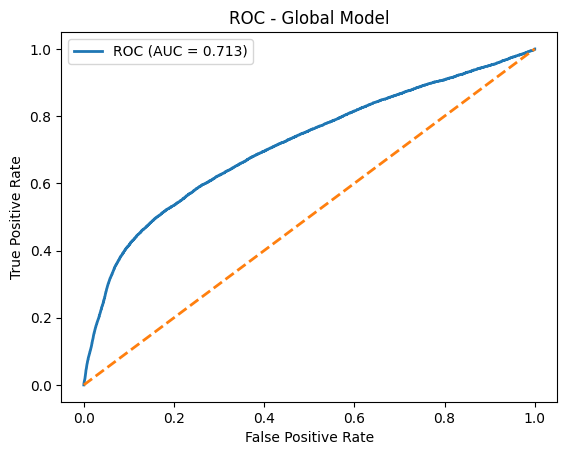

In [31]:
# -----------------------
# Load & evaluate final global model
# -----------------------
final_model_path = os.path.join(LOG_DIR, f"global_model_round{NUM_ROUNDS}.pth")
if not os.path.exists(final_model_path):
    candidates = sorted([f for f in os.listdir(LOG_DIR) if f.startswith("global_model_round")])
    if candidates:
        final_model_path = os.path.join(LOG_DIR, candidates[-1])
        print("Using saved model:", final_model_path)
    else:
        raise FileNotFoundError("No saved global model found in logs.")

final_state = torch.load(final_model_path)
global_model = SepsisNet()
global_model.load_state_dict(final_state)
global_model.to(DEVICE).eval()

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        out = global_model(Xb)
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_labels.extend(yb.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))
fpr, tpr, thr = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Global Model")
plt.legend()
plt.show()